In [19]:
"""
from google.colab import files
uploaded = files.upload()
"""

'\nfrom google.colab import files\nuploaded = files.upload()\n'

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


consumos = pd.read_excel("Estadisticas gasolina.xlsx", sheet_name="CONSUMO")

consumos = consumos.dropna(how='all')

consumos.columns = consumos.columns.str.strip()
consumos['Fecha'] = pd.to_datetime(consumos['Fecha'], errors='coerce')

consumos = consumos.dropna(subset=['Fecha'])
consumos.set_index('Fecha', inplace=True)

gasolina_regular = consumos[['Gasolina regular']]
gasolina_superior = consumos[['Gasolina superior']]

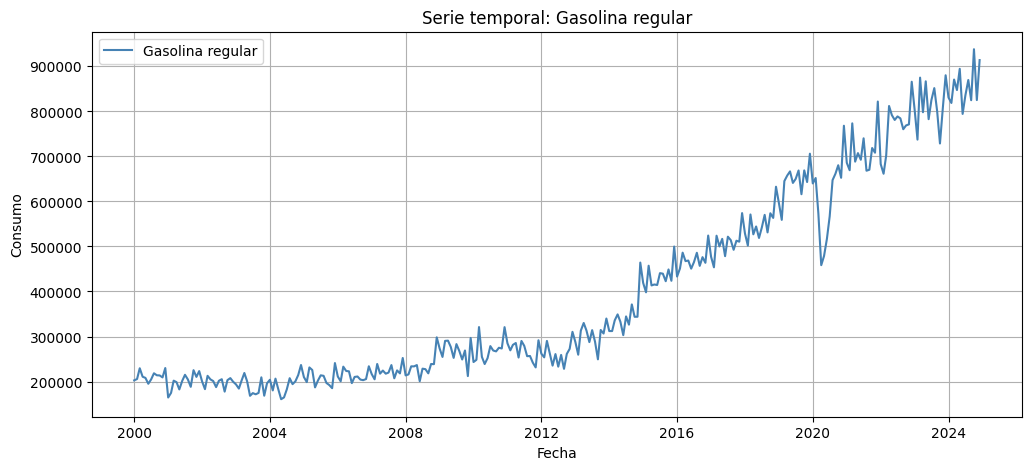

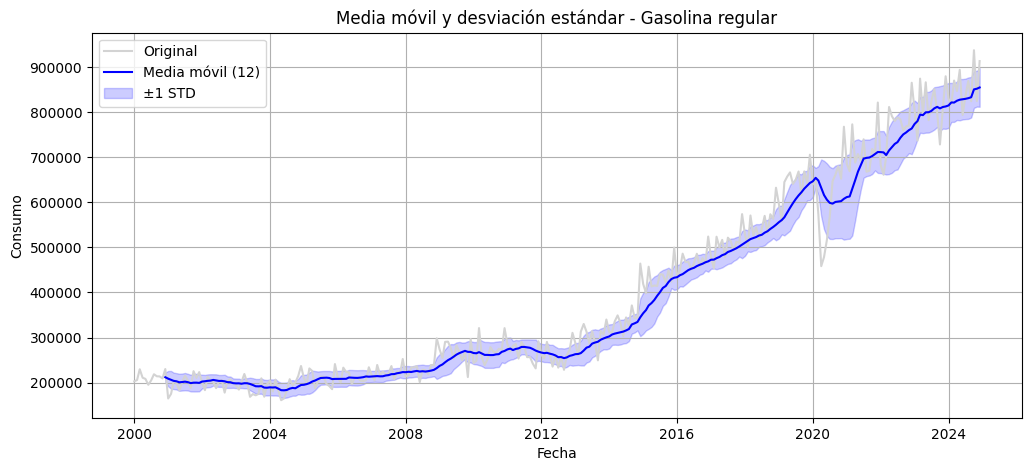

In [21]:
# Serie original
plt.figure(figsize=(12, 5))
plt.plot(gasolina_regular, label='Gasolina regular', color='steelblue')
plt.title('Serie temporal: Gasolina regular')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.legend()
plt.show()

# Media móvil y desviación estándar (ventana 12 meses)
media_movil = gasolina_regular.rolling(window=12).mean()
desviacion_std = gasolina_regular.rolling(window=12).std()

plt.figure(figsize=(12, 5))
plt.plot(gasolina_regular, label='Original', color='lightgray')
plt.plot(media_movil, label='Media móvil (12)', color='blue')
plt.fill_between(gasolina_regular.index,
                 (media_movil - desviacion_std).squeeze(),
                 (media_movil + desviacion_std).squeeze(),
                 color='blue', alpha=0.2, label='±1 STD')

plt.title('Media móvil y desviación estándar - Gasolina regular')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.legend()
plt.show()


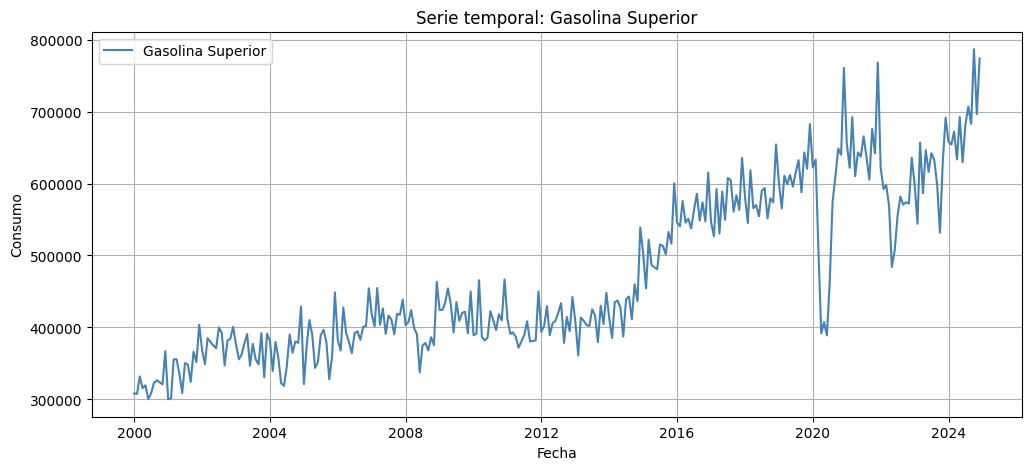

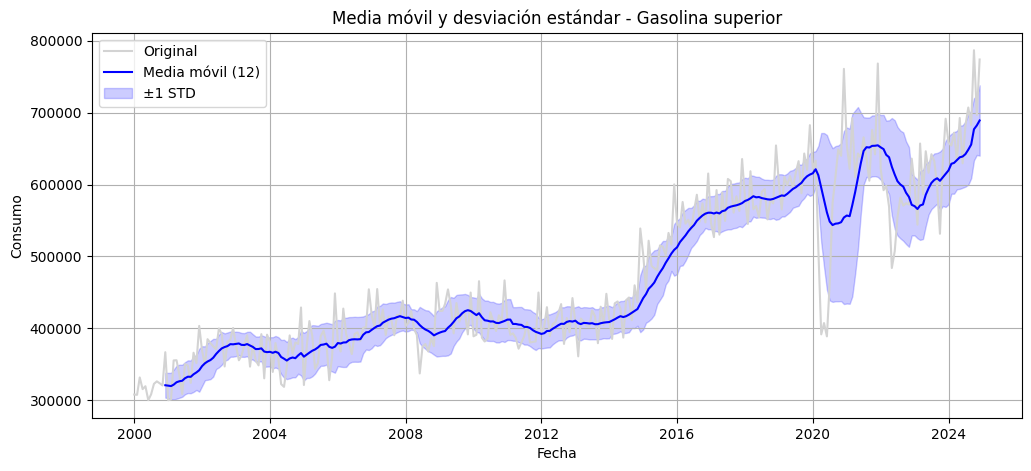

In [22]:
plt.figure(figsize=(12, 5))
plt.plot(gasolina_superior, label='Gasolina Superior', color='steelblue')
plt.title('Serie temporal: Gasolina Superior')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.legend()
plt.show()

# Media móvil y desviación estándar (ventana 12 meses)
media_movil = gasolina_superior.rolling(window=12).mean()
desviacion_std = gasolina_superior.rolling(window=12).std()

plt.figure(figsize=(12, 5))
plt.plot(gasolina_superior, label='Original', color='lightgray')
plt.plot(media_movil, label='Media móvil (12)', color='blue')
plt.fill_between(gasolina_superior.index,
                 (media_movil - desviacion_std).squeeze(),
                 (media_movil + desviacion_std).squeeze(),
                 color='blue', alpha=0.2, label='±1 STD')

plt.title('Media móvil y desviación estándar - Gasolina superior')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def crear_secuencias(data, pasos):
    X, y = [], []
    for i in range(len(data) - pasos):
        X.append(data[i:i+pasos])
        y.append(data[i+pasos])
    return np.array(X), np.array(y)

def preparar_datos_lstm(serie, pasos=12, porcentaje_entrenamiento=0.8):
    scaler = MinMaxScaler()
    data_scaled = scaler.fit_transform(serie.values.reshape(-1, 1))

    X, y = crear_secuencias(data_scaled, pasos)

    split = int(len(X) * porcentaje_entrenamiento)
    X_train, y_train = X[:split], y[:split]
    X_test, y_test = X[split:], y[split:]

    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test, scaler, data_scaled, split


In [24]:
#Modelo LSTM simple
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def modelo_lstm_simple(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


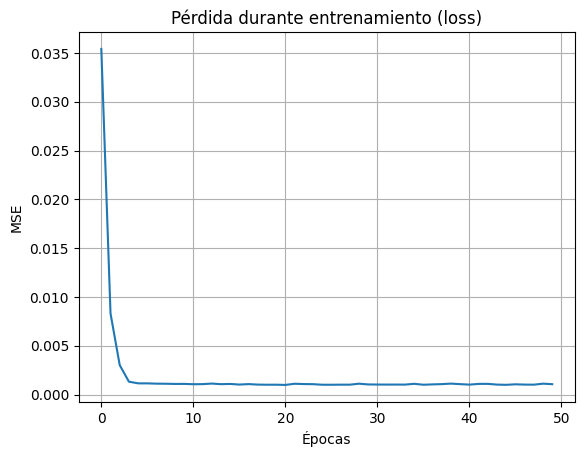

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x14cb96b00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


In [25]:
# Preparacion datos Gasolina Regular
X_train, y_train, X_test, y_test, scaler, data_scaled, split = preparar_datos_lstm(gasolina_regular, pasos=12)

# Crear y entrenar modelo
modelo = modelo_lstm_simple((X_train.shape[1], 1))
hist = modelo.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Graficar la pérdida
plt.plot(hist.history['loss'])
plt.title("Pérdida durante entrenamiento (loss)")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

# Predecir y desescalar
pred_scaled = modelo.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
real = scaler.inverse_transform(y_test.reshape(-1, 1))


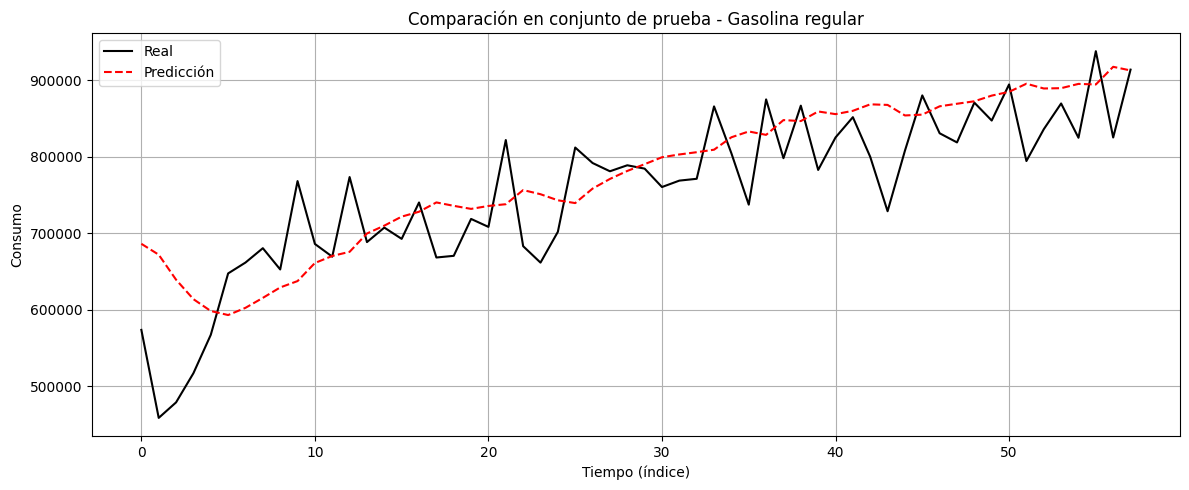

In [26]:
#Mediciones gasolina regular
plt.figure(figsize=(12, 5))
plt.plot(real, label='Real', color='black')
plt.plot(pred, label='Predicción', color='red', linestyle='--')
plt.title('Comparación en conjunto de prueba - Gasolina regular')
plt.xlabel('Tiempo (índice)')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


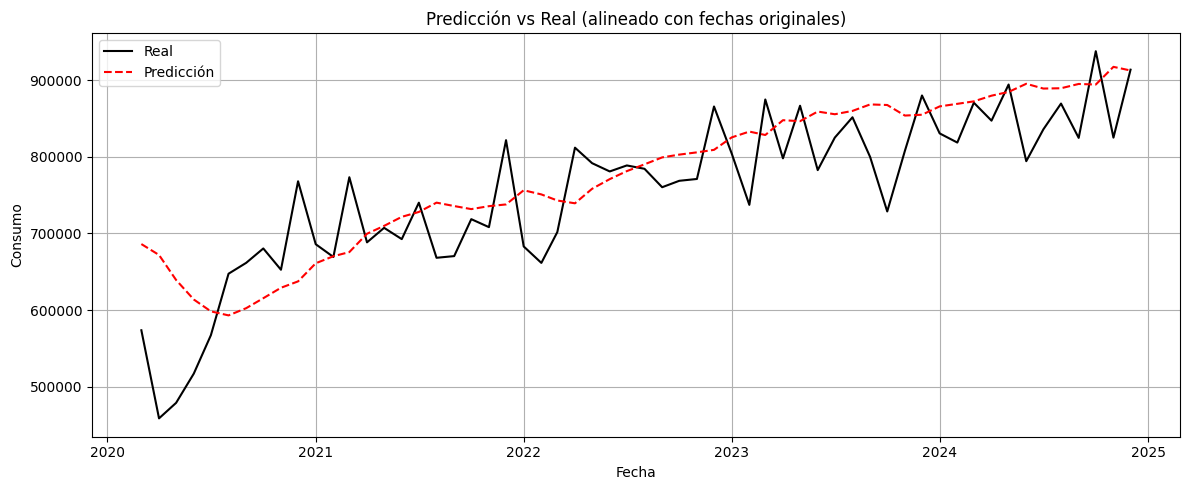

In [27]:
# Crear serie completa para comparación
pasos = 12
index_total = gasolina_regular.index
index_test = index_total[pasos + split : pasos + split + len(pred)]

serie_pred = pd.Series(pred.flatten(), index=index_test)
serie_real = gasolina_regular.iloc[pasos + split : pasos + split + len(pred)]

plt.figure(figsize=(12, 5))
plt.plot(serie_real, label='Real', color='black')
plt.plot(serie_pred, label='Predicción', color='red', linestyle='--')
plt.title('Predicción vs Real (alineado con fechas originales)')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

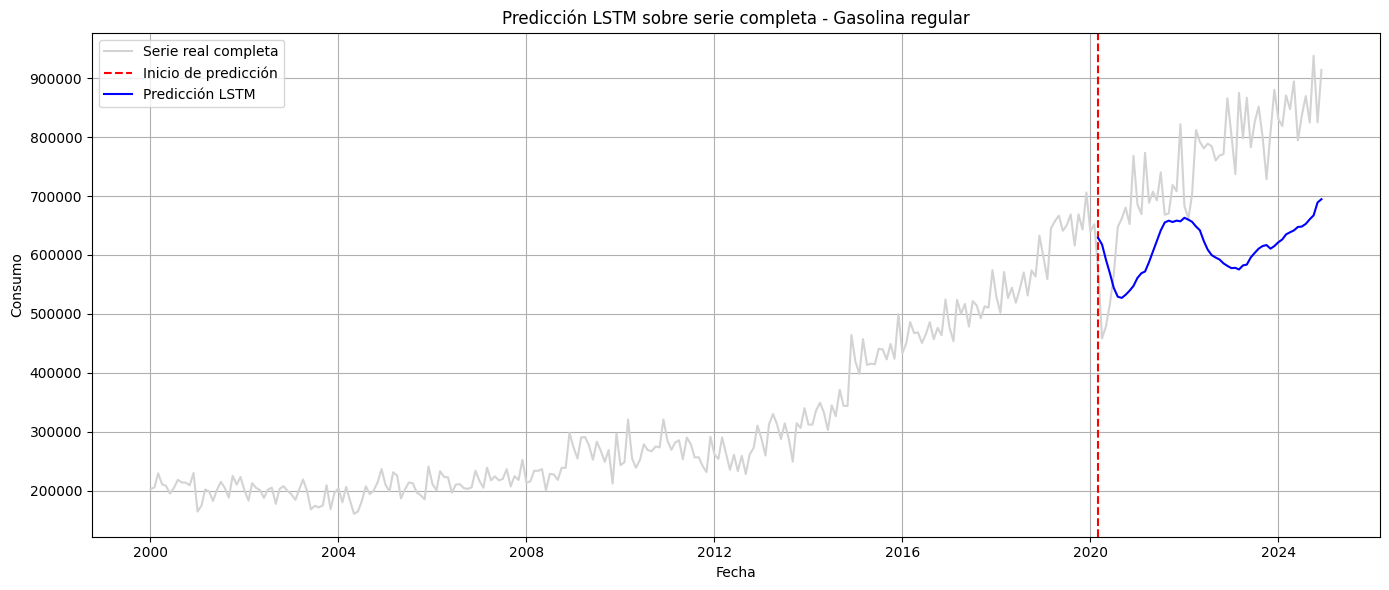

In [17]:
# Crear índices para serie original y predicción
index_total = gasolina_regular.index
index_pred = index_total[pasos + split : pasos + split + len(pred)]

# Serie real original
serie_real = gasolina_regular.squeeze()

# Serie predicha con mismo índice
serie_pred = pd.Series(pred.flatten(), index=index_pred)

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(serie_real, label='Serie real completa', color='lightgray')
plt.axvline(index_pred[0], color='red', linestyle='--', label='Inicio de predicción')
plt.plot(serie_pred, label='Predicción LSTM', color='blue')

plt.title("Predicción LSTM sobre serie completa - Gasolina regular")
plt.xlabel("Fecha")
plt.ylabel("Consumo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


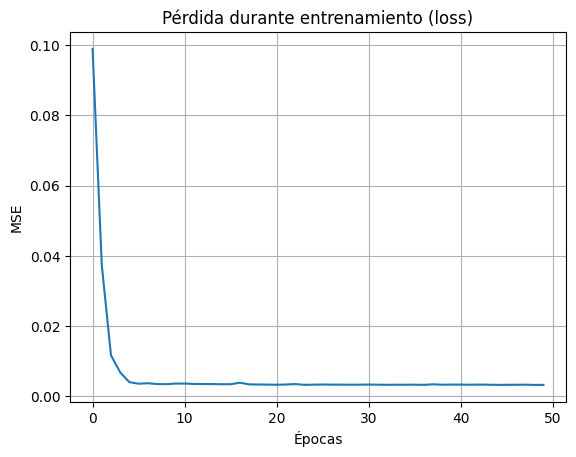

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [28]:
# Preparacion datos Gasolina Superior
# Preparar datos
X_train, y_train, X_test, y_test, scaler, data_scaled, split = preparar_datos_lstm(gasolina_superior, pasos=12)

# Crear y entrenar modelo
modelo = modelo_lstm_simple((X_train.shape[1], 1))
hist = modelo.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

# Graficar la pérdida
plt.plot(hist.history['loss'])
plt.title("Pérdida durante entrenamiento (loss)")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.grid(True)
plt.show()

# Predecir y desescalar
pred_scaled = modelo.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
real = scaler.inverse_transform(y_test.reshape(-1, 1))


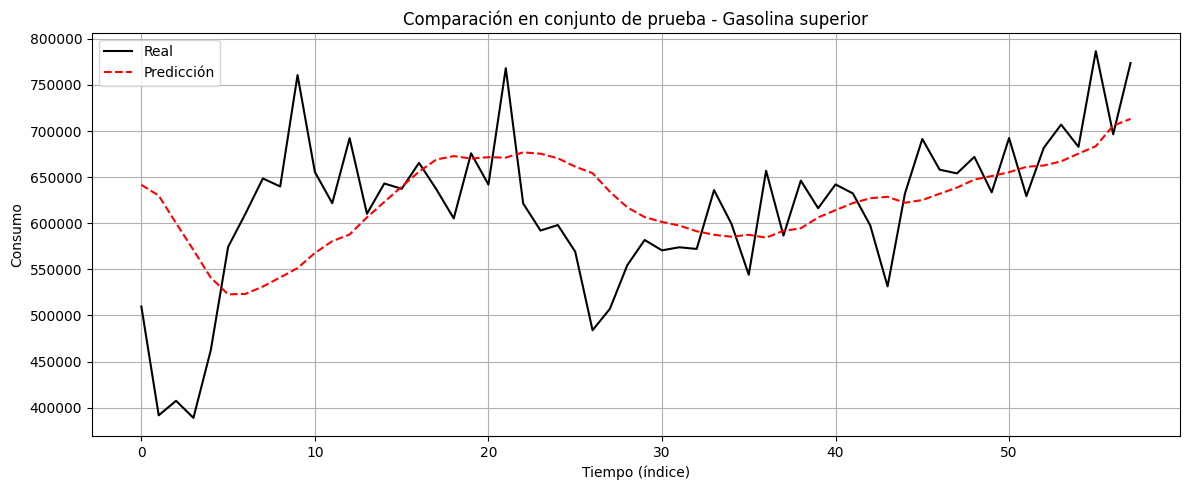

In [29]:
#Mediciones gasolina Superior
plt.figure(figsize=(12, 5))
plt.plot(real, label='Real', color='black')
plt.plot(pred, label='Predicción', color='red', linestyle='--')
plt.title('Comparación en conjunto de prueba - Gasolina superior')
plt.xlabel('Tiempo (índice)')
plt.ylabel('Consumo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


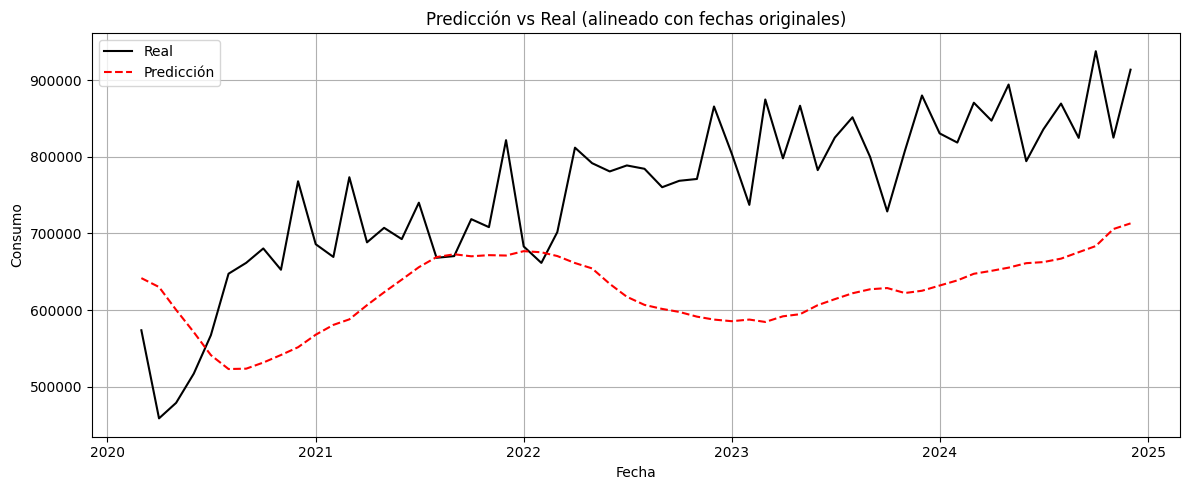

In [30]:
# Crear serie completa para comparación
pasos = 12
index_total = gasolina_superior.index
index_test = index_total[pasos + split : pasos + split + len(pred)]

serie_pred = pd.Series(pred.flatten(), index=index_test)
serie_real = gasolina_regular.iloc[pasos + split : pasos + split + len(pred)]

plt.figure(figsize=(12, 5))
plt.plot(serie_real, label='Real', color='black')
plt.plot(serie_pred, label='Predicción', color='red', linestyle='--')
plt.title('Predicción vs Real (alineado con fechas originales)')
plt.xlabel('Fecha')
plt.ylabel('Consumo')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


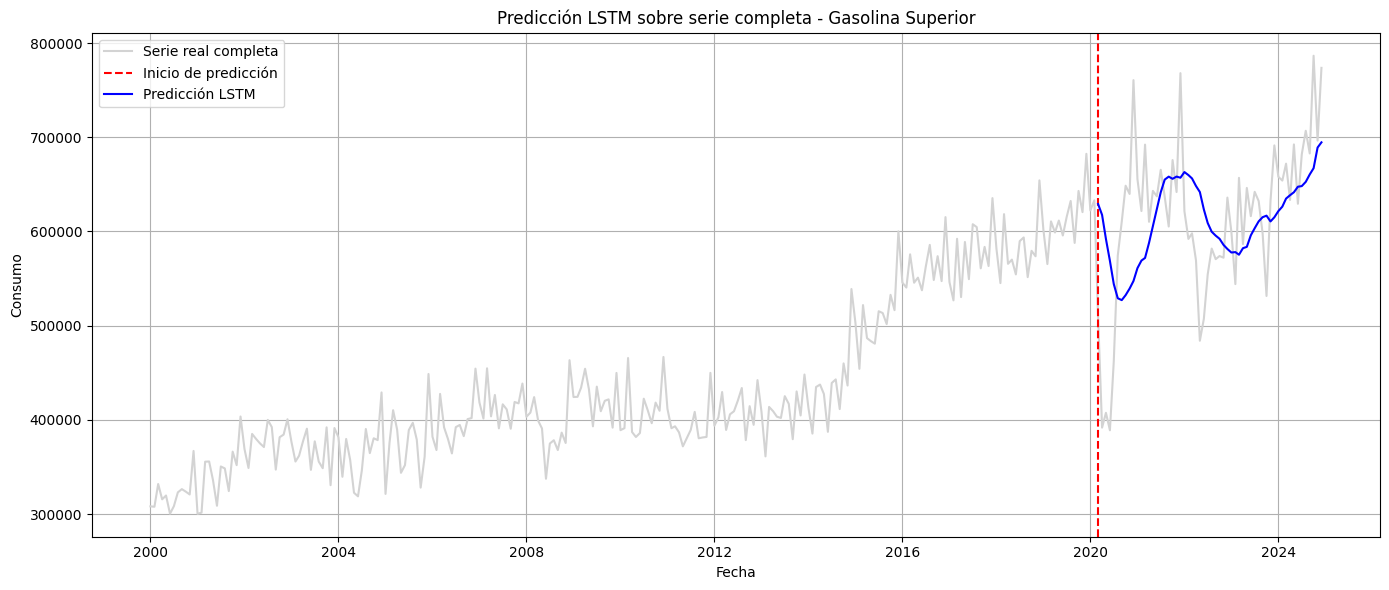

In [18]:
# Crear índices para serie original y predicción
index_total = gasolina_superior.index
index_pred = index_total[pasos + split : pasos + split + len(pred)]

# Serie real original
serie_real = gasolina_superior.squeeze()

# Serie predicha con mismo índice
serie_pred = pd.Series(pred.flatten(), index=index_pred)

# Graficar
plt.figure(figsize=(14, 6))
plt.plot(serie_real, label='Serie real completa', color='lightgray')
plt.axvline(index_pred[0], color='red', linestyle='--', label='Inicio de predicción')
plt.plot(serie_pred, label='Predicción LSTM', color='blue')

plt.title("Predicción LSTM sobre serie completa - Gasolina Superior")
plt.xlabel("Fecha")
plt.ylabel("Consumo")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
